# Parallel ViT-CNN Hybrid with MURA

## GPU Availability Check

We start with GPU availability check.

In [1]:
import tensorflow as tf
import torch

print(f"Tensorflow Version: {tf.__version__}")
print(f"TF GPU Available: {tf.config.list_physical_devices('GPU')}")

print(f"\nPyTourch Version: {torch.__version__}")
print(f"PyTourch GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Tensorflow Version: 2.20.0
TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTourch Version: 2.10.0+cu128
PyTourch GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU


## Dataset loading

We define the Aseptic Loose Hip Implant X-Ray Database dataset,

In [2]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

class HipImplantManager:
    def __init__(self, root_dir='/tf/data/loose_hips'):
        """
        Args:
            root_dir (string): Path to the root folder containing /loose and /control.
        """
        self.root_dir = root_dir
        self.target_classes = ['control', 'loose']
        self.data = []

        # 1. Scan directories and build a list of file paths and class names
        for class_name in self.target_classes:
            class_folder = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_folder):
                print(f"Warning: Folder {class_folder} not found.")
                continue
                
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append({
                        'filepath': os.path.join(class_folder, img_name),
                        'class_name': class_name
                    })

        self.df = pd.DataFrame(self.data)

        # 2. Encode Labels using LabelEncoder
        self.encoder = LabelEncoder()
        # fit_transform converts 'control'/'loose' into 0/1 (alphabetically or by order of appearance)
        self.df['label'] = self.encoder.fit_transform(self.df['class_name'])
        
        print(f"Loaded {len(self.df)} images.")
        print("Class Mapping:")
        for idx, cls in enumerate(self.encoder.classes_):
            print(f"{idx}: {cls}")

    def get_splits(self, train_size=0.8, val_size=0.1, test_size=0.1):
        """
        Splits the dataset into train, validation, and test sets.
        Uses stratified splitting to ensure balanced classes in each split.
        """
        # Split into Train and Temp (Val + Test)
        train_df, temp_df = train_test_split(
            self.df, 
            train_size=train_size, 
            stratify=self.df['label'], 
            random_state=42
        )

        # Split Temp into Val and Test
        relative_val_size = val_size / (val_size + test_size)
        val_df, test_df = train_test_split(
            temp_df, 
            train_size=relative_val_size, 
            stratify=temp_df['label'], 
            random_state=42
        )

        return train_df, val_df, test_df

class HipImplantDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepath']
        label = row['label']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback for missing/corrupt files
            print(f"Warning: Could not load {img_path}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

.. and define custom resize transformation,

In [3]:
from torchvision import transforms
import torchvision.transforms.functional as TF

class LetterboxResize:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def __call__(self, img):
        # 1. Resize the image such that the longest side matches target_size
        w, h = img.size
        max_side = max(self.target_size)
        scale = max_side / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = TF.resize(img, (new_h, new_w))

        # 2. Pad the shorter side to make it square
        delta_w = self.target_size[0] - new_w
        delta_h = self.target_size[1] - new_h
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Use a constant background color (black or gray)
        return TF.pad(img, padding, fill=0, padding_mode='constant')

.. and from such definition, we instantiate datasets.

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 1. Initialize Manager
manager = HipImplantManager('/tf/data/loose_hips') 
train_df, val_df, test_df = manager.get_splits()

# 2. Define Transforms (Reusing LetterboxResize from your notebook)
train_transform = transforms.Compose([
    LetterboxResize(target_size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    LetterboxResize(target_size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Create Dataset Objects
train_ds = HipImplantDataset(train_df, transform=train_transform)
val_ds = HipImplantDataset(val_df, transform=val_test_transform)
test_ds = HipImplantDataset(test_df, transform=val_test_transform)

# 4. Create Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

Loaded 206 images.
Class Mapping:
0: control
1: loose
Train size: 164 | Val size: 21 | Test size: 21


## Training

We define training step,

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # Conformer outputs: [logits_cnn, logits_trans]
        out_cnn, out_trans = model(images)

        # Combined loss as suggested in Conformer paper
        loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # For accuracy, we usually average the predictions or use the transformer head
        prediction = (out_cnn + out_trans).argmax(dim=1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. and validation step,

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm 

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            out_cnn, out_trans = model(images)
            loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

            total_loss += loss.item()
            prediction = (out_cnn + out_trans).argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. silence warning

In [7]:
import warnings
warnings.filterwarnings("ignore")

.. and perform training

In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
import os

# Get the absolute path to your Conformer folder
path_to_conformer = os.path.abspath('./Conformer')
if path_to_conformer not in sys.path:
    sys.path.insert(0, path_to_conformer)

from models import Conformer_small_patch16

# --- Hyperparameters & Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer_small_patch16(num_classes=7).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# --- Early Stopping Parameters ---
epoch_number = 100          # Set a high max epochs, early stopping will handle the rest
patience = 5               # How many epochs to wait for improvement before stopping
min_delta = 0.001          # Minimum change to qualify as an improvement
early_stop_counter = 0     # Internal counter
best_val_loss = float('inf') 
best_val_acc = 0.0

for epoch in range(epoch_number):
    # 1. Training & Validation steps
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # 2. Checkpointing (Save model based on Best Accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_conformer_loose_hips.pth')
        print("  --> Model Checkpointed (New Best Accuracy)!")

    # 3. Early Stopping Logic (Based on Validation Loss)
    if val_loss < (best_val_loss - min_delta):
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter because we found a significant improvement
        print(f"  --> Val Loss improved. Resetting early stopping counter.")
    else:
        early_stop_counter += 1
        print(f"  --> Val Loss did not improve. Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"\n[!] Early stopping triggered. Training stopped at epoch {epoch}.")
        break

Training: 100% 6/6 [00:18<00:00,  3.03s/it]
Validating: 100% 1/1 [00:00<00:00,  1.83it/s]


Epoch 0:
  Train Loss: 2.6416 | Acc: 39.02%
  Val Loss:   2.3346 | Acc: 42.86%
  --> Model Checkpointed (New Best Accuracy)!
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.87s/it]
Validating: 100% 1/1 [00:00<00:00,  2.04it/s]


Epoch 1:
  Train Loss: 1.8017 | Acc: 58.54%
  Val Loss:   2.0688 | Acc: 57.14%
  --> Model Checkpointed (New Best Accuracy)!
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.84s/it]
Validating: 100% 1/1 [00:00<00:00,  2.10it/s]


Epoch 2:
  Train Loss: 1.6629 | Acc: 56.10%
  Val Loss:   1.8140 | Acc: 52.38%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:16<00:00,  2.81s/it]
Validating: 100% 1/1 [00:00<00:00,  2.04it/s]


Epoch 3:
  Train Loss: 1.5215 | Acc: 59.76%
  Val Loss:   1.7381 | Acc: 42.86%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:16<00:00,  2.82s/it]
Validating: 100% 1/1 [00:00<00:00,  2.01it/s]


Epoch 4:
  Train Loss: 1.4628 | Acc: 59.15%
  Val Loss:   1.6007 | Acc: 47.62%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.84s/it]
Validating: 100% 1/1 [00:00<00:00,  2.06it/s]


Epoch 5:
  Train Loss: 1.4073 | Acc: 59.76%
  Val Loss:   1.5786 | Acc: 47.62%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.84s/it]
Validating: 100% 1/1 [00:00<00:00,  2.09it/s]


Epoch 6:
  Train Loss: 1.3885 | Acc: 63.41%
  Val Loss:   1.6262 | Acc: 42.86%
  --> Val Loss did not improve. Early stopping counter: 1/5


Training: 100% 6/6 [00:17<00:00,  2.84s/it]
Validating: 100% 1/1 [00:00<00:00,  2.06it/s]


Epoch 7:
  Train Loss: 1.5206 | Acc: 60.98%
  Val Loss:   1.4986 | Acc: 52.38%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.83s/it]
Validating: 100% 1/1 [00:00<00:00,  2.05it/s]


Epoch 8:
  Train Loss: 1.3893 | Acc: 62.80%
  Val Loss:   1.4080 | Acc: 47.62%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:16<00:00,  2.83s/it]
Validating: 100% 1/1 [00:00<00:00,  2.08it/s]


Epoch 9:
  Train Loss: 1.4079 | Acc: 64.63%
  Val Loss:   1.4686 | Acc: 57.14%
  --> Val Loss did not improve. Early stopping counter: 1/5


Training: 100% 6/6 [00:16<00:00,  2.83s/it]
Validating: 100% 1/1 [00:00<00:00,  2.04it/s]


Epoch 10:
  Train Loss: 1.3359 | Acc: 62.80%
  Val Loss:   1.4641 | Acc: 57.14%
  --> Val Loss did not improve. Early stopping counter: 2/5


Training: 100% 6/6 [00:17<00:00,  2.85s/it]
Validating: 100% 1/1 [00:00<00:00,  1.79it/s]


Epoch 11:
  Train Loss: 1.3373 | Acc: 63.41%
  Val Loss:   1.3929 | Acc: 52.38%
  --> Val Loss improved. Resetting early stopping counter.


Training: 100% 6/6 [00:17<00:00,  2.85s/it]
Validating: 100% 1/1 [00:00<00:00,  2.07it/s]


Epoch 12:
  Train Loss: 1.3039 | Acc: 68.29%
  Val Loss:   1.4503 | Acc: 57.14%
  --> Val Loss did not improve. Early stopping counter: 1/5


Training: 100% 6/6 [00:16<00:00,  2.83s/it]
Validating: 100% 1/1 [00:00<00:00,  2.08it/s]


Epoch 13:
  Train Loss: 1.2601 | Acc: 67.68%
  Val Loss:   1.4642 | Acc: 52.38%
  --> Val Loss did not improve. Early stopping counter: 2/5


Training: 100% 6/6 [00:16<00:00,  2.83s/it]
Validating: 100% 1/1 [00:00<00:00,  2.03it/s]


Epoch 14:
  Train Loss: 1.2495 | Acc: 65.85%
  Val Loss:   1.4843 | Acc: 61.90%
  --> Model Checkpointed (New Best Accuracy)!
  --> Val Loss did not improve. Early stopping counter: 3/5


Training: 100% 6/6 [00:17<00:00,  2.85s/it]
Validating: 100% 1/1 [00:00<00:00,  2.03it/s]


Epoch 15:
  Train Loss: 1.2449 | Acc: 68.90%
  Val Loss:   1.4455 | Acc: 61.90%
  --> Val Loss did not improve. Early stopping counter: 4/5


Training: 100% 6/6 [00:17<00:00,  2.84s/it]
Validating: 100% 1/1 [00:00<00:00,  2.04it/s]

Epoch 16:
  Train Loss: 1.2720 | Acc: 62.80%
  Val Loss:   1.4584 | Acc: 57.14%
  --> Val Loss did not improve. Early stopping counter: 5/5

[!] Early stopping triggered. Training stopped at epoch 16.


## Evaluation

### Confusion matrix

We evaluate model by plotting confusion matrix,

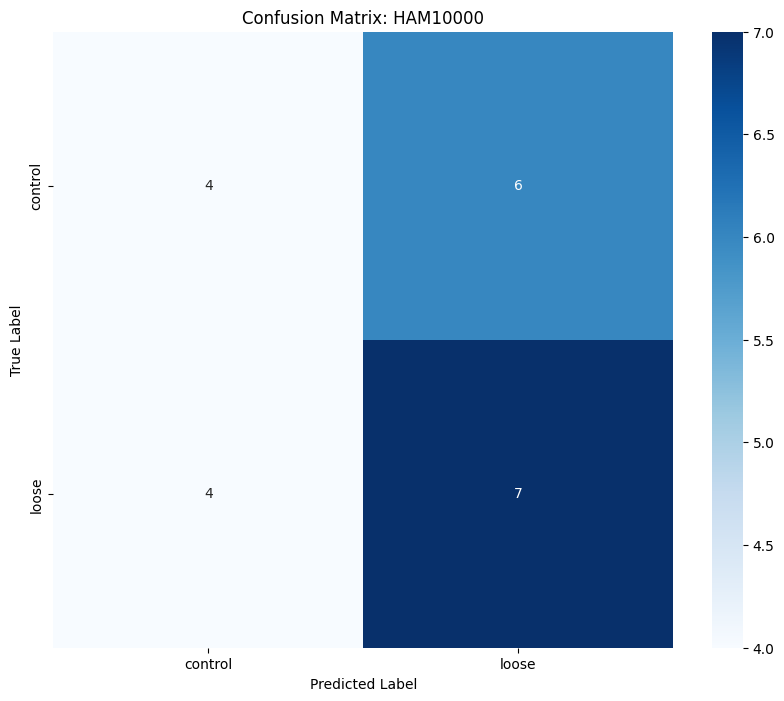


Classification Report:

              precision    recall  f1-score   support

     control       0.50      0.40      0.44        10
       loose       0.54      0.64      0.58        11

    accuracy                           0.52        21
   macro avg       0.52      0.52      0.51        21
weighted avg       0.52      0.52      0.52        21



In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Conformer dual-output handling: average the branches for prediction
            out_cnn, out_trans = model(images)
            outputs = (out_cnn + out_trans) / 2

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: HAM10000')
    plt.show()

    # Also print the detailed F1-score/Recall report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Usage:
# Get names from the encoder we defined in the Manager class
class_names = manager.encoder.classes_
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

.. also plot PR-curve,

### POC curve

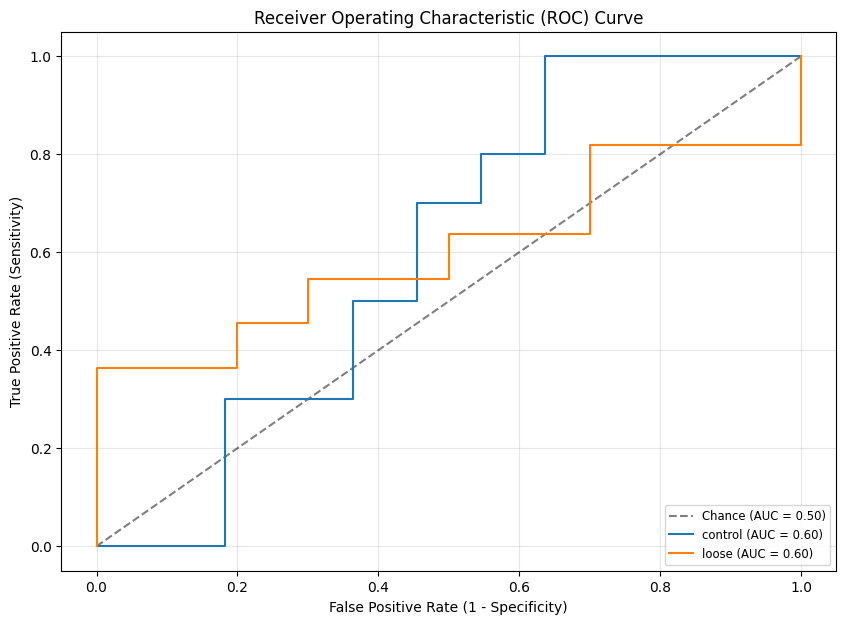

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_curve(model, loader, device, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Handling the hybrid model output
            out_cnn, out_trans = model(images)
            # Use averaged probabilities
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    y_true = np.concatenate(all_labels)
    Y_score = np.concatenate(all_probs)
    n_classes = len(class_names)

    # Standardize label format for multiclass/binary
    if n_classes == 2:
        Y_test = np.zeros((len(y_true), 2))
        Y_test[np.arange(len(y_true)), y_true] = 1
    else:
        Y_test = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 7))

    # Plot diagonal "chance" line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Chance (AUC = 0.50)')

    for i in range(n_classes):
        # Calculate False Positive Rate and True Positive Rate
        fpr, tpr, _ = roc_curve(Y_test[:, i], Y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(alpha=0.3)
    plt.show()

# Usage:
plot_roc_curve(model, test_loader, DEVICE, manager.encoder.classes_)

## Explanation

Let's try to explain how our model works.

### GradCAM for CNN branch

We start with explaining how CNN branch works with Grad-CAM,

Automatically targeted layer: Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
True Class: control | Predicted Class: loose


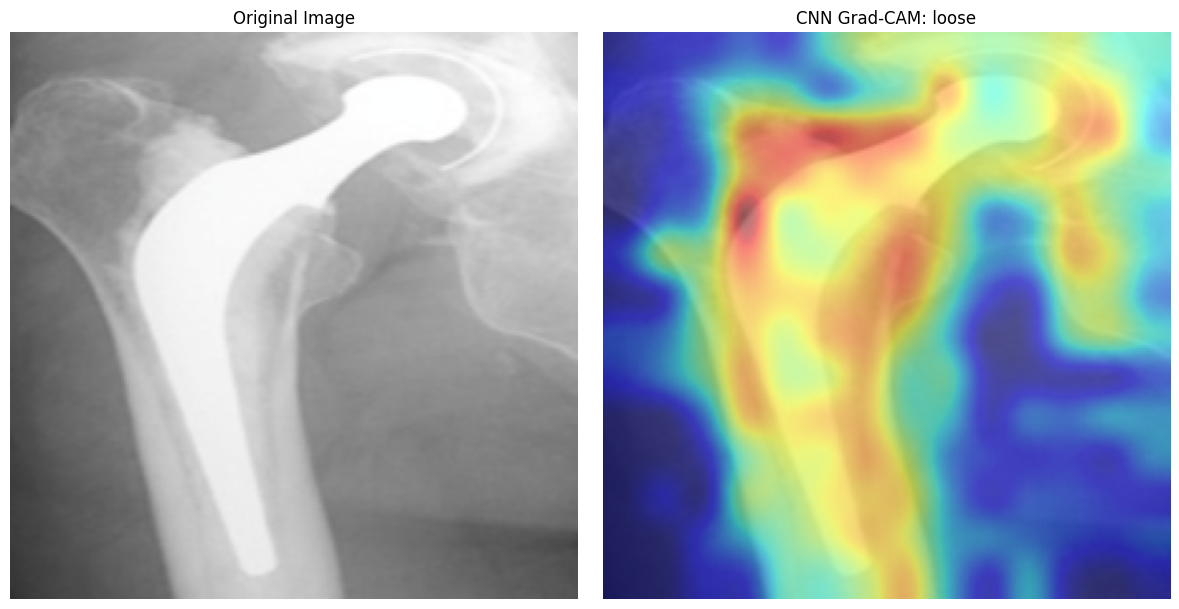

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

class CNN_GradCAM:
    def __init__(self, model, target_layer=None):
        self.model = model
        self.model.eval()
        self.features = None
        self.gradients = None

        # Automatically find the last Conv2d layer if not specified
        if target_layer is None:
            target_layer = self._find_last_conv_layer()
            print(f"Automatically targeted layer: {target_layer}")

        # Register hooks
        self._register_hooks(target_layer)

    def _find_last_conv_layer(self):
        # Heuristic to find the last Conv2d layer (usually part of the CNN block)
        last_conv = None
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                last_conv = module
        return last_conv

    def _register_hooks(self, layer):
        def forward_hook(module, input, output):
            self.features = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        layer.register_forward_hook(forward_hook)
        layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        # 1. Forward Pass
        self.model.zero_grad()
        # Conformer specific: Unpack the tuple
        out_cnn, out_trans = self.model(input_image)

        # 2. Select Target
        if target_class is None:
            # Determine class based on combined logic
            final_pred = (out_cnn + out_trans).argmax(dim=1)
            target_class = final_pred.item()

        # 3. Backward Pass on CNN Output ONLY
        score = out_cnn[0, target_class]
        score.backward()

        # 4. Generate Grad-CAM weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Weighted combination of feature maps
        cam = torch.sum(weights * self.features, dim=1, keepdim=True)

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize to 0-1
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)

        return cam.cpu().detach().numpy()[0, 0], target_class

def visualize_cam(original_img_tensor, cam_mask, class_name):
    """
    Visualizes Grad-CAM using PIL and Matplotlib (No OpenCV).
    """
    # 1. Convert tensor to numpy image (H, W, C)
    img = original_img_tensor.cpu().numpy().transpose(1, 2, 0)

    # 2. Denormalize (assuming ImageNet means/stds)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 3. Resize CAM to match Original Image using PIL
    # Scale CAM to 0-255 uint8 for PIL processing
    cam_uint8 = np.uint8(255 * cam_mask)
    cam_pil = Image.fromarray(cam_uint8, 'L') # 'L' mode for grayscale

    # Upsample using Bicubic interpolation
    original_h, original_w = img.shape[:2]
    cam_pil_resized = cam_pil.resize((original_w, original_h), resample=Image.BICUBIC)

    # Convert back to numpy float 0-1
    cam_resized = np.array(cam_pil_resized) / 255.0

    # 4. Apply Colormap (Jet) using Matplotlib
    # cm.jet returns (H, W, 4) RGBA, we only need RGB
    heatmap = cm.jet(cam_resized)[..., :3]

    # 5. Superimpose
    alpha = 0.5
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    # 6. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(overlay)
    ax[1].set_title(f"CNN Grad-CAM: {class_name}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Example Usage Logic ---
# (Assumes 'model', 'test_loader', 'DEVICE', and 'class_names' are defined from previous cells)

# 1. Instantiate the CAM object
# We let it auto-find the last conv layer in the CNN branch
grad_cam = CNN_GradCAM(model)

# 2. Get a sample image
img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)
true_class_name = manager.encoder.classes_[label[0].item()]

# 3. Generate CAM
mask, pred_class_idx = grad_cam.generate_cam(input_image)
pred_class_name = manager.encoder.classes_[pred_class_idx]

# 4. Visualize
print(f"True Class: {true_class_name} | Predicted Class: {pred_class_name}")
visualize_cam(input_image[0], mask, pred_class_name)

### Attention Rollout for Transformer branch

.. the we explain transformer with Attention Rollout,

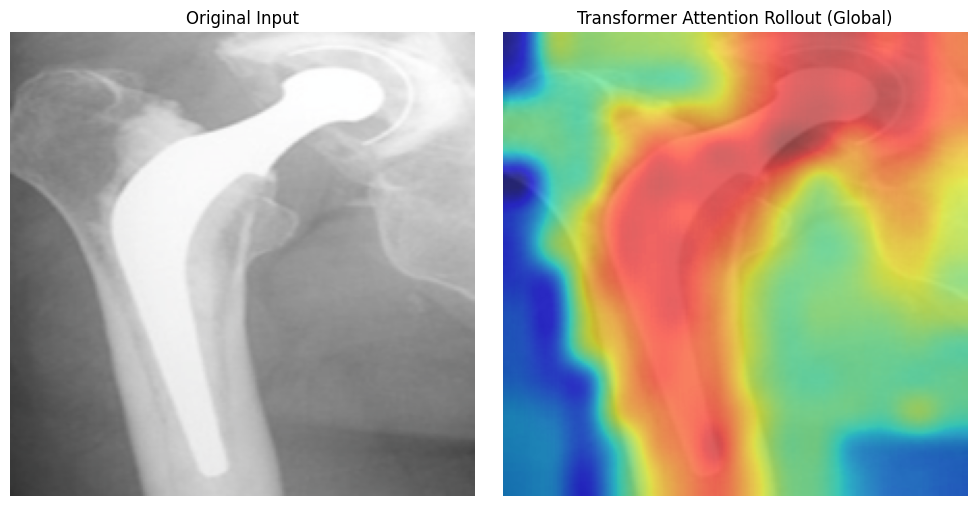

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

class ConformerRollout:
    def __init__(self, model):
        self.model = model
        self.attentions = []
        self.hooks = []

    def _get_attn_hook(self):
        def hook(module, input, output):
            # The input to the dropout layer in a standard ViT Attention block
            # is the attention matrix (Batch, Heads, Tokens, Tokens)
            # We capture input[0] because input is a tuple
            self.attentions.append(input[0].detach().cpu())
        return hook

    def register_hooks(self):
        """
        Recursively finds all 'attn_drop' modules in the model (standard in timm/Conformer)
        and registers a forward hook to capture attention weights.
        """
        self.attentions = []
        self.hooks = []
        for name, module in self.model.named_modules():
            # 'attn_drop' is the standard name in the Conformer source code for
            # the dropout layer applied to the Softmax(Q@K) matrix.
            if "attn_drop" in name:
                self.hooks.append(module.register_forward_hook(self._get_attn_hook()))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def generate_rollout(self, input_tensor, discard_ratio=0.9):
        """
        Computes the Attention Rollout mask.
        """
        self.register_hooks()

        # 1. Forward Pass
        self.model.eval()
        self.model.zero_grad()
        with torch.no_grad():
            # Handle potential tuple output from Conformer
            _ = self.model(input_tensor)

        self.remove_hooks()

        if not self.attentions:
            print("Error: No attention layers captured. Check layer names.")
            return None

        # 2. Compute Rollout
        # Start with Identity Matrix to represent residual connections
        # Shape: (Tokens, Tokens) matching the last layer
        num_tokens = self.attentions[0].size(-1)
        result = torch.eye(num_tokens)

        # Iterate from input layer to output layer
        for attn in self.attentions:
            # attn shape: (1, Heads, Tokens, Tokens)
            # We average attention weights across all heads
            attn_fused = attn.mean(axis=1)[0] # Shape: (Tokens, Tokens)

            # To account for Residual Connections in the Transformer Block (x + Attention(x)),
            # we add the Identity matrix and re-normalize.
            # Formula: A_hat = 0.5 * A + 0.5 * I
            attn_fused = attn_fused + torch.eye(attn_fused.size(0))
            attn_fused = attn_fused / attn_fused.sum(dim=-1, keepdim=True)

            # Recursive Multiplication: Rollout_l = A_l * Rollout_{l-1}
            result = torch.matmul(attn_fused, result)

        # 3. Extract Class Token Attention
        # The first token (index 0) is the CLS token. We want to see what pixels
        # it attended to.
        mask = result[0, 1:] # Drop index 0 (self-attention to CLS)

        # Reshape to 2D map
        # For 224x224 image and patch size 16, we expect 14x14 = 196 patches
        width = int(np.sqrt(mask.size(0)))
        mask = mask.reshape(width, width).numpy()

        # Normalize for visualization (0 to 1)
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        return mask

def visualize_rollout(original_img_tensor, mask, alpha=0.6):
    """
    Visualizes Attention Rollout using PIL and Matplotlib (No OpenCV).
    """
    # 1. Convert tensor to numpy image (H, W, C)
    img = original_img_tensor.cpu().numpy().transpose(1, 2, 0)

    # 2. Denormalize (assuming ImageNet normalization used in the notebook)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 3. Resize mask to match image dimensions using PIL
    # Scale mask to 0-255 uint8
    mask_uint8 = np.uint8(255 * mask)
    mask_pil = Image.fromarray(mask_uint8, mode='L')

    # Resize using Bicubic interpolation for smooth heatmap
    original_h, original_w = img.shape[:2]
    mask_resized_pil = mask_pil.resize((original_w, original_h), resample=Image.BICUBIC)

    # Convert back to float 0-1
    mask_resized = np.array(mask_resized_pil) / 255.0

    # 4. Apply Colormap (Jet) using Matplotlib
    # cm.jet returns RGBA (H, W, 4), discard Alpha channel
    heatmap = cm.jet(mask_resized)[..., :3]

    # 5. Overlay
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    # 6. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img)
    ax[0].set_title("Original Input")
    ax[0].axis('off')

    ax[1].imshow(overlay)
    ax[1].set_title("Transformer Attention Rollout (Global)")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)

# 2. Instantiate and Run
rollout_explainer = ConformerRollout(model)
mask = rollout_explainer.generate_rollout(input_image)

# 3. Visualize
if mask is not None:
    visualize_rollout(input_image[0], mask)

### Integrated Gradient for whole model

.. adn then integrated gradient for holistic model explanation.

Computing Integrated Gradients... (this may take a moment)
Convergence Delta: -0.8543931245803833 (Lower is better)


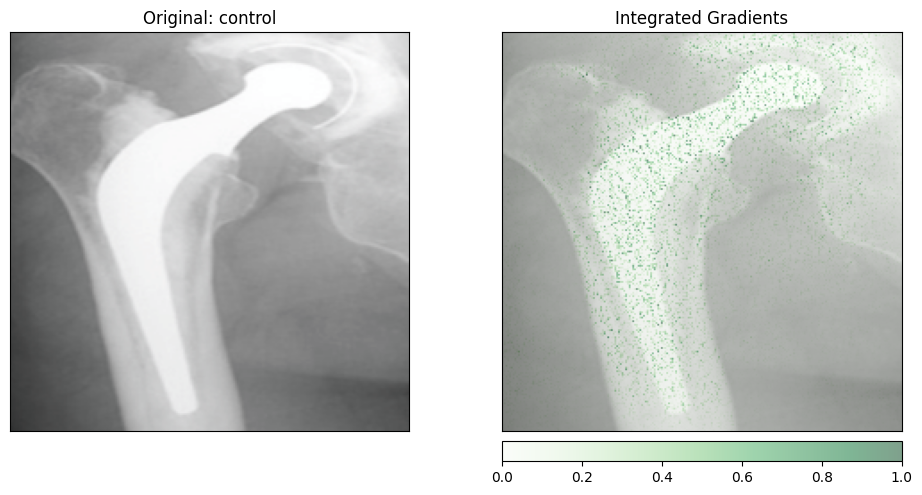

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

class ConformerWrapper(nn.Module):
    """
    Wraps the Conformer to fuse the two branches into a single output.
    This ensures IG explains the actual decision mechanism.
    """
    def __init__(self, conformer_model):
        super(ConformerWrapper, self).__init__()
        self.model = conformer_model

    def forward(self, x):
        # 1. Forward pass through original model
        out_cnn, out_trans = self.model(x)

        # 2. Fuse outputs (Summation, as per notebook logic)
        return out_cnn + out_trans

def explain_with_ig(model, input_tensor, target_class_idx, class_names):
    """
    Computes and visualizes Integrated Gradients.
    """
    # 1. Wrap the model
    wrapped_model = ConformerWrapper(model)
    wrapped_model.eval()

    # 2. Initialize IG
    ig = IntegratedGradients(wrapped_model)

    # 3. Compute Attributions
    # We attribute the decision to the input pixels relative to a black baseline
    print("Computing Integrated Gradients... (this may take a moment)")
    attributions, delta = ig.attribute(
        input_tensor,
        target=target_class_idx,
        baselines=torch.zeros_like(input_tensor),
        n_steps=50, # Higher steps = more accurate approximation of the integral
        return_convergence_delta=True
    )

    print(f"Convergence Delta: {delta.item()} (Lower is better)")

    # 4. Prepare for Visualization
    # Transpose to (H, W, C) for Matplotlib
    attr_np = attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    img_np = input_tensor[0].cpu().detach().numpy().transpose(1, 2, 0)

    # Denormalize Image (Restoring original colors)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # 5. Visualize
    # 'blended_heat_map' overlays the attribution on the image
    viz.visualize_image_attr_multiple(
        attr_np,
        img_np,
        methods=["original_image", "blended_heat_map"],
        signs=["all", "positive"],
        show_colorbar=True,
        titles=[f"Original: {class_names[target_class_idx]}", "Integrated Gradients"],
        fig_size=(10, 5)
    )

# 1. Get a single sample
img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)
target_class = label[0].item()

# 2. Get class names (if available from manager)
try:
    class_names = manager.encoder.classes_
except:
    class_names = [f"Class {i}" for i in range(7)]

# 3. Run Explanation
explain_with_ig(model, input_image, target_class, class_names)